# Introduction

## Aim:

Making risk prediction based on given features.

## Context:

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## Content:
1. [Data Understanding](#1)
    * [Load and Check Data](#2)
    * [Variable Description](#3)
    * [Data Visualization](#4)
1. [Data Preprocessing](#5)                          
1. [Modeling](#6)
    * [Confusion Matrix](#7)
    * [Decision Tree Model](#8)
    * [Random Forest Model](#9)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report, roc_curve

import warnings # ignore warning
warnings.filterwarnings("ignore")

%matplotlib inline

<a id="1"></a>
# 1) Data Understanding

<a id="2"></a>
## Load and Check Data

In [5]:
# Reading and copying data
# YOUR CODE HERE
data = pd.read_csv('german_credit_data.csv')
df = data.copy()

* Overview of data

In [6]:
# Overview of data
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


<a id="3"></a>
## Variable Description

Meaning of the Values:

1. Age: Age of the person applying for the credit.
1. Sex: Gender of the person applying for the credit.
1. Job: The values specified for the job in the form of 0,1,2,3 (0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
1. Housing: Own, rent or free.
1. Saving accounts: The amount of money in the person's bank account.
1. Checking account: Cheque account.
1. Credit amount: Credit amount.
1. Duration: Time given for credit payment.
1. Purpose: Goal of credit application.
1. Risk: Credit application positive or negative.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


Summary of the Columns and Rows:

* int64(4): Age, Job, Credit amount, Duration
* object(6): Sex, Housing, Saving accounts, Checking account, Purpose, Risk
* row number: 1000
* column number: 10

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,499.500,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,35.546,11.375469,19.0,27.00,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.00,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.50,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.00,18.0,24.00,72.0


Summary of Statistics of Numerical Values:

* Age: max 75.0, min 19.0, mean 35.546
* Job: max 3.0, min 0.0, mean 1.904
* Credit amount: max 18424.0, min 250.0, mean 3271.258
* Duration: max 72.0, min 4.0, mean 20.903

In [9]:
columns = ["Age", "Sex", "Job", "Housing", "Saving accounts", "Checking account", "Credit amount", "Duration", "Purpose", "Risk"]

def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:\n", unique_value(df, columns))    

Number of the Unique Values:
 Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


Number of the Unique Values:

* Age(53):
* Sex(2): (male, female)
* Job(4): (0, 1, 2, 3)
* Housing(3): (own, free, rent)
* Saving accounts(4): (little, moderate, quite rich, rich)
* Checking account(3): (little, moderate, rich)
* Credit amount(921):
* Duration(33):
* Purpose(8): (radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others)
* Risk(2): (bad, good)

In [10]:
# Missing Value Table
def missing_value_table(df):
    missing_value = df.isna().sum().sort_values(ascending=False)
    missing_value_percent = 100 * df.isna().sum() // len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
    missing_value_table_return = missing_value_table.rename(columns={0: 'Missing Values', 1: '% Value'})
    cm = sns.light_palette("lightgreen", as_cmap=True)
    missing_value_table_return = missing_value_table_return.style.background_gradient(cmap=cm)
    return missing_value_table_return


missing_value_table(df)

,Missing Values,% Value
Checking account,394,39
Saving accounts,183,18
Unnamed: 0,0,0
Age,0,0
Sex,0,0
Job,0,0
Housing,0,0
Credit amount,0,0
Duration,0,0
Purpose,0,0


Number of Missing Values:

* Checking account: number of missing value 394, percent of missing value 39
* Saving accounts: number of missing value 183, percent of missing value18

In [11]:
date_int = ["Purpose", 'Sex']
cm = sns.light_palette("lightgreen", as_cmap=True)
pd.crosstab(df[date_int[0]], df[date_int[1]]).style.background_gradient(cmap=cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


Sex and Purpose:

* Women(94) and Men(243) applied for credit mostly for cars.
* Women(3) applied for credit least for vacation/others.
* Men(6) applied for credit least for domestic appliances.

<a id="4"></a>
## Data Visualization

Text(0.5, 1.0, 'Good - Bad Risk Ratio')

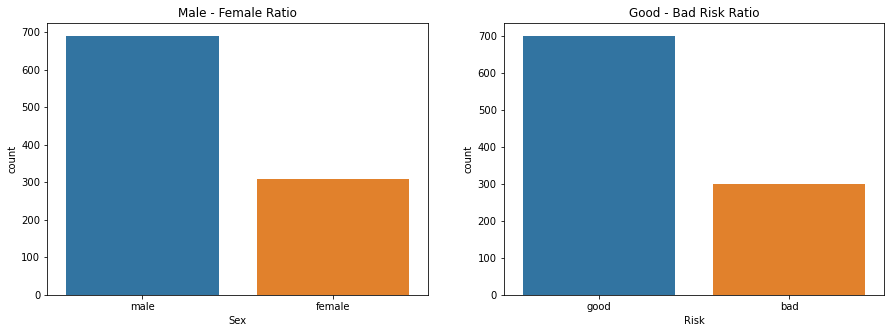

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(df['Sex'], ax=ax[0]).set_title('Male - Female Ratio')
sns.countplot(df.Risk, ax=ax[1]).set_title('Good - Bad Risk Ratio')

* Looking at the graphics, the rate of males in this data set is higher than the rate of females.
* Looking at the graphics, the rate of good risk in this data set is higher than the rate of bad risk.

<AxesSubplot:xlabel='Duration', ylabel='Credit amount'>

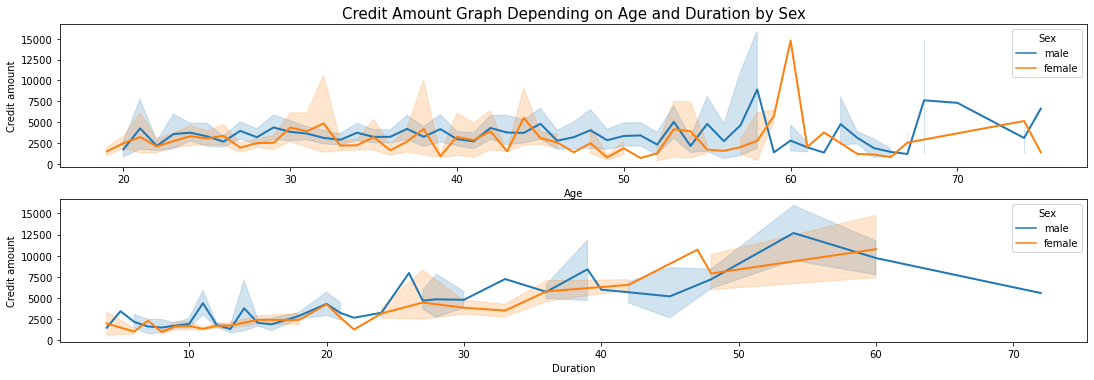

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
plt.tight_layout()
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15)
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1])

* Looking at the chart, the highest credit amount was reached at the age of 60 and around.
* Looking at the graph, the highest loan amounts between 50-60 duration have been reached.

<AxesSubplot:xlabel='Housing', ylabel='count'>

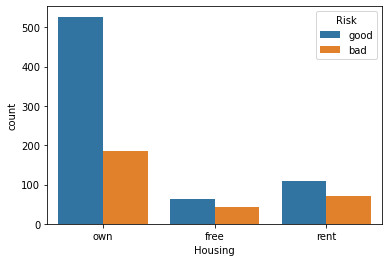

In [25]:
# Using sns.countplot to show frequency of "Housing" by "Risk"
# YOUR CODE HERE
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# sns.countplot(df['Sex'], ax=ax[0]).set_title('Male - Female Ratio')
# sns.countplot(df.Risk, ax=ax[1]).set_title('Good - Bad Risk Ratio')

sns.countplot(x=df.Housing, hue=df.Risk)

#sns.countplot(df['Sex'], ax=ax[0]).set_title('Male - Female Ratio')
#sns.countplot(df.Risk, ax=ax[1]).set_title('Good - Bad Risk Ratio')


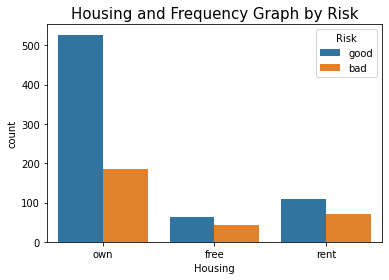

In [11]:
# DON'T WRITE HERE

* The risk rates are higher in the own, free and rent categories then bad risk.
* Owners of their own homes are the people who apply for a loan the most.

[Text(0, 0, 'little'), Text(1, 0, 'moderate'), Text(2, 0, 'rich')]

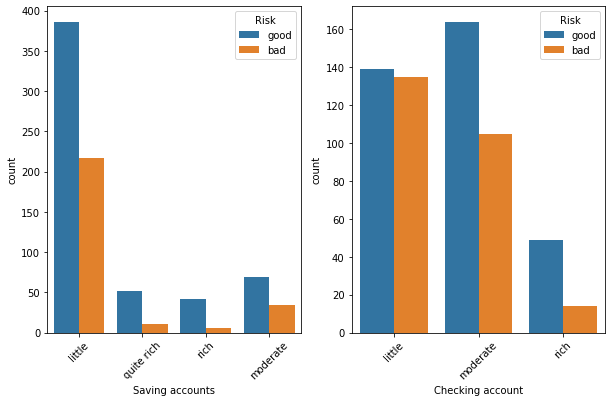

In [39]:
# Using sns.countplot to show frequency of "Saving accounts" and "Checking account" by "Risk"
# YOUR CODE HERE
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.countplot(data=df, x="Saving accounts", hue="Risk", ax = ax[0])
sns.countplot(data=df, x="Checking account", hue="Risk", ax = ax[1])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


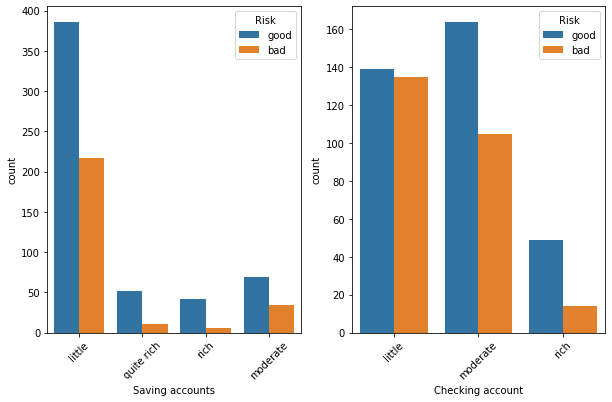

In [12]:
# DON'T WRITE HERE


* At first scan, it is thought that the rich people will get more credit, but it does not seem to be clearly on the graphics.

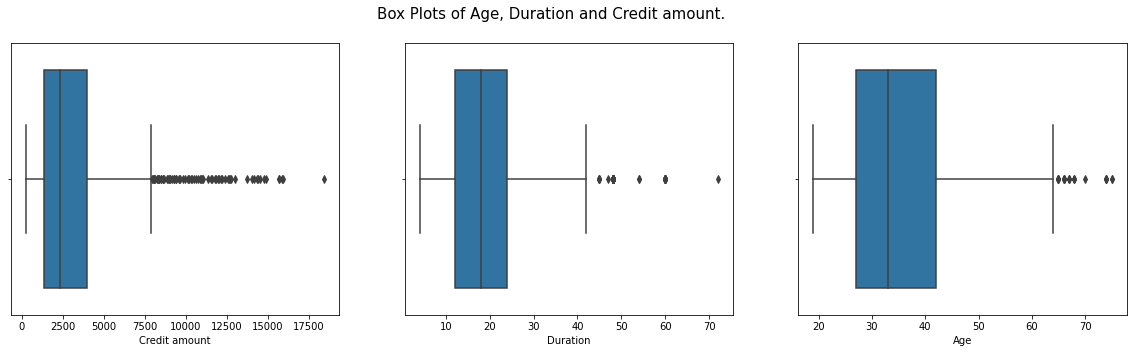

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Box Plots of Age, Duration and Credit amount.', fontsize=15)
sns.boxplot(df['Credit amount'], ax=ax[0])
sns.boxplot(df['Duration'], ax=ax[1])
sns.boxplot(df['Age'], ax=ax[2])
plt.show()

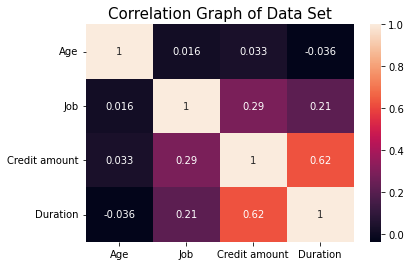

In [14]:
cor = df.corr()
sns.heatmap(cor, annot=True).set_title("Correlation Graph of Data Set", fontsize=15)
plt.show()

* There is a correlation between Credit amount and Duration(0.62).

<a id="5"></a>
# 2) Data Preprocessing

* Label encoding

In [48]:
# Using LabelEncoder() to encode the value of columns "Sex" and "Risk"
# YOUR CODE HERE
le = LabelEncoder()
le.fit(df[["Sex", "Risk"]])
df2 = le.transform(df[["Sex", "Risk"]])
df2.head()

ValueError: y should be a 1d array, got an array of shape (1000, 2) instead.

In [15]:
# DON'T WRITE HERE

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,NaN,little,1169,6,radio/TV,1
1,22,0,2,own,little,moderate,5951,48,radio/TV,0
2,49,1,1,own,little,NaN,2096,12,education,1
3,45,1,2,free,little,little,7882,42,furniture/equipment,1
4,53,1,2,free,little,little,4870,24,car,0


* Converting age to category.

In [16]:
Cat_Age = []
for i in df["Age"]:
    if i < 25:
        Cat_Age.append("0-25")
    elif (i >= 25) and (i < 30):
        Cat_Age.append("25-30")
    elif (i >= 30) and (i < 35):
        Cat_Age.append("30-35")
    elif (i >= 35) and (i < 40):
        Cat_Age.append("35-40")
    elif (i >= 40) and (i < 50):
        Cat_Age.append("40-50")
    elif (i >= 50) and (i < 76):
        Cat_Age.append("50-75")

df["Cat Age"] = Cat_Age

df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Cat Age
0,67,1,2,own,NaN,little,1169,6,radio/TV,1,50-75
1,22,0,2,own,little,moderate,5951,48,radio/TV,0,0-25
2,49,1,1,own,little,NaN,2096,12,education,1,40-50
3,45,1,2,free,little,little,7882,42,furniture/equipment,1,40-50
4,53,1,2,free,little,little,4870,24,car,0,50-75


* Used get dummies method for some columns.

In [ ]:
# Using pd.concat and pd.get_dummies to create one-hot-encoding of the following columns
columns_dummy = ['Housing', 'Saving accounts', 'Checking account', "Purpose", "Cat Age"]
#YOUR CODE HERE


In [17]:
# DON'T WRITE HERE

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,...,furniture/equipment,radio/TV,repairs,vacation/others,0-25,25-30,30-35,35-40,40-50,50-75
0,67,1,2,own,NaN,little,1169,6,radio/TV,1,...,0,1,0,0,0,0,0,0,0,1
1,22,0,2,own,little,moderate,5951,48,radio/TV,0,...,0,1,0,0,1,0,0,0,0,0
2,49,1,1,own,little,NaN,2096,12,education,1,...,0,0,0,0,0,0,0,0,1,0
3,45,1,2,free,little,little,7882,42,furniture/equipment,1,...,1,0,0,0,0,0,0,0,1,0
4,53,1,2,free,little,little,4870,24,car,0,...,0,0,0,0,0,0,0,0,0,1


* Drop unnecessary columns.

In [ ]:
# Drop unnecessary columns: Housing, Saving accounts, Checking account, Purpose, Age, Cat Age
# YOUR CODE HERE


In [18]:
# DON'T WRITE HERE

,Sex,Job,Credit amount,Duration,Risk,free,own,rent,little,moderate,...,furniture/equipment,radio/TV,repairs,vacation/others,0-25,25-30,30-35,35-40,40-50,50-75
0,1,2,1169,6,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,2,5951,48,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0
2,1,1,2096,12,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,2,7882,42,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
4,1,2,4870,24,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


!!! Missing values were not filled or droped because when filled or droped, the accuracy value was decreasing. 

<a id="6"></a>
# 3) Modeling

* Separated data as train and test.

In [19]:
y = df.Risk
X = df.drop("Risk", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Applied standart scaling.

In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

<a id="7"></a>
## Confusion Matrix

| \ | Predicted | Predicted |
| :- | :- | :- |
| Actual | Bad ('0') [N] | Good ('1') [P] |
| Bad ('0') [N] | 0 [TN] | 5 [FP] |
| Good ('1') [P]  | 1 [FN] | 0 [TP] |


<b>Rows</b>: actual classification

<b>Columns</b>: predicted classification

('0' = Bad Credit Risk, '1' = Good Credit Risk)

Note, that we have consider here the Good Credit Risk ('1'), as the positive class [P].

<a id="8"></a>
## Decision Tree Model

* Train model

In [21]:
# Initialize model
model = DecisionTreeClassifier(class_weight='balanced', random_state=2)
# Fit to train data
model.fit(X_train, y_train)
# Predict on test data
y_pred = model.predict(X_test)
# Check accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\n")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy:  0.685


Confusion matrix:
 [[ 31  28]
 [ 35 106]]


Classification report:
               precision    recall  f1-score   support

           0       0.47      0.53      0.50        59
           1       0.79      0.75      0.77       141

    accuracy                           0.69       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.70      0.69      0.69       200



* Before Tuning accuracy score is 0.685. Using GridSearchCV to find the best Hyper Parameters of model.

In [22]:
# Initialize model
model = DecisionTreeClassifier(class_weight='balanced', random_state=2)

# Seting the Hyper Parameters
param_grid = {"max_depth": [3, 5, 7, 10, None],
              "min_samples_leaf": [5, 4, 3, 2, 1],
              "max_features": [4, 7, 15, 20, None]}

# Find the best Hyper Parameters
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END max_depth=3, max_features=4, min_samples_leaf=5;, score=0.640 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, min_samples_leaf=5;, score=0.554 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, min_samples_leaf=5;, score=0.518 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, min_samples_leaf=5;, score=0.696 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, min_samples_leaf=5;, score=0.732 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, min_samples_leaf=4;, score=0.640 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, min_samples_leaf=4;, score=0.554 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, min_samples_leaf=4;, score=0.518 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, min_samples_leaf=4;, score=0.696 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, min_samples_leaf=4;, score=0.732 total time=   0.

[CV 2/5] END max_depth=5, max_features=7, min_samples_leaf=4;, score=0.768 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=7, min_samples_leaf=4;, score=0.670 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=7, min_samples_leaf=4;, score=0.598 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=7, min_samples_leaf=4;, score=0.696 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=7, min_samples_leaf=3;, score=0.757 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=7, min_samples_leaf=3;, score=0.768 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=7, min_samples_leaf=3;, score=0.661 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=7, min_samples_leaf=3;, score=0.634 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=7, min_samples_leaf=3;, score=0.661 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=7, min_samples_leaf=2;, score=0.757 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=7, min_samples_leaf=2

[CV 3/5] END max_depth=7, max_features=15, min_samples_leaf=1;, score=0.571 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=15, min_samples_leaf=1;, score=0.750 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=15, min_samples_leaf=1;, score=0.696 total time=   0.0s
[CV 1/5] END max_depth=7, max_features=20, min_samples_leaf=5;, score=0.658 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=20, min_samples_leaf=5;, score=0.643 total time=   0.0s
[CV 3/5] END max_depth=7, max_features=20, min_samples_leaf=5;, score=0.732 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=20, min_samples_leaf=5;, score=0.679 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=20, min_samples_leaf=5;, score=0.643 total time=   0.0s
[CV 1/5] END max_depth=7, max_features=20, min_samples_leaf=4;, score=0.685 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=20, min_samples_leaf=4;, score=0.652 total time=   0.0s
[CV 3/5] END max_depth=7, max_features=20, min_sam

[CV 2/5] END max_depth=10, max_features=20, min_samples_leaf=2;, score=0.661 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=20, min_samples_leaf=2;, score=0.670 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=20, min_samples_leaf=2;, score=0.723 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=20, min_samples_leaf=2;, score=0.732 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=20, min_samples_leaf=1;, score=0.757 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=20, min_samples_leaf=1;, score=0.741 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=20, min_samples_leaf=1;, score=0.732 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=20, min_samples_leaf=1;, score=0.741 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=20, min_samples_leaf=1;, score=0.696 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=None, min_samples_leaf=5;, score=0.730 total time=   0.0s
[CV 2/5] END max_depth=10, max_feature

[CV 4/5] END max_depth=None, max_features=None, min_samples_leaf=5;, score=0.652 total time=   0.0s
[CV 5/5] END max_depth=None, max_features=None, min_samples_leaf=5;, score=0.598 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=None, min_samples_leaf=4;, score=0.793 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=None, min_samples_leaf=4;, score=0.696 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=None, min_samples_leaf=4;, score=0.634 total time=   0.0s
[CV 4/5] END max_depth=None, max_features=None, min_samples_leaf=4;, score=0.741 total time=   0.0s
[CV 5/5] END max_depth=None, max_features=None, min_samples_leaf=4;, score=0.607 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=None, min_samples_leaf=3;, score=0.766 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=None, min_samples_leaf=3;, score=0.688 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=None, min_samples_leaf=3;, score=0.661 total time=   0.0s


* Retrain model with the best Hyper Parameters

In [23]:
# Initialize model
model = DecisionTreeClassifier(class_weight='balanced', max_depth=None, max_features=None, min_samples_leaf=1, random_state=2)
# Fit to train data
model.fit(X_train, y_train)
# Predict on test data
y_pred = model.predict(X_test)
# Check accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\n")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy:  0.685


Confusion matrix:
 [[ 31  28]
 [ 35 106]]


Classification report:
               precision    recall  f1-score   support

           0       0.47      0.53      0.50        59
           1       0.79      0.75      0.77       141

    accuracy                           0.69       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.70      0.69      0.69       200



* After Tuning accuracy score same with before tuning so, 0.685. Check ROC curve

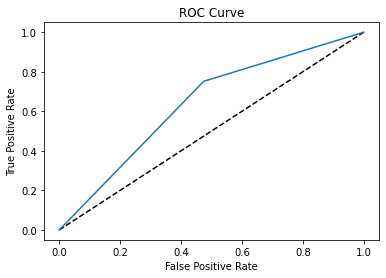

In [24]:
# Predicting proba
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<a id="9"></a>
## Random Forest Model

* Train model

In [ ]:
# YOUR CODE HERE


In [25]:
# DON'T WRITE HERE

Accuracy:  0.745


Confusion matrix:
 [[ 23  36]
 [ 15 126]]


Classification report:
               precision    recall  f1-score   support

           0       0.61      0.39      0.47        59
           1       0.78      0.89      0.83       141

    accuracy                           0.74       200
   macro avg       0.69      0.64      0.65       200
weighted avg       0.73      0.74      0.73       200



* Before Tuning accuracy score is 0.745. Using GridSearchCV to find the best Hyper Parameters of model.

In [ ]:
# YOUR CODE HERE


In [26]:
# DON'T WRITE HERE

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.622 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.643 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.705 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.670 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.786 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.640 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.741 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.634 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.688 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.830 total time=   0.0s
[CV 1/5] END max_depth=3, max_feature

[CV 4/5] END max_depth=3, max_features=20, n_estimators=5;, score=0.616 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=20, n_estimators=5;, score=0.696 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.766 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.723 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.607 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.714 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.777 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=20, n_estimators=25;, score=0.784 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=20, n_estimators=25;, score=0.741 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=20, n_estimators=25;, score=0.652 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=20, n_estimators=25;, score=0.714 total tim

[CV 4/5] END max_depth=5, max_features=7, n_estimators=25;, score=0.750 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=7, n_estimators=25;, score=0.786 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=7, n_estimators=50;, score=0.802 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=7, n_estimators=50;, score=0.777 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=7, n_estimators=50;, score=0.705 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=7, n_estimators=50;, score=0.759 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=7, n_estimators=50;, score=0.812 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=7, n_estimators=150;, score=0.802 total time=   0.1s
[CV 2/5] END max_depth=5, max_features=7, n_estimators=150;, score=0.768 total time=   0.1s
[CV 3/5] END max_depth=5, max_features=7, n_estimators=150;, score=0.714 total time=   0.1s
[CV 4/5] END max_depth=5, max_features=7, n_estimators=150;, score=0.768 total time=   

[CV 1/5] END max_depth=5, max_features=None, n_estimators=50;, score=0.793 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=None, n_estimators=50;, score=0.696 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=None, n_estimators=50;, score=0.741 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=None, n_estimators=50;, score=0.786 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=None, n_estimators=50;, score=0.768 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=None, n_estimators=150;, score=0.784 total time=   0.1s
[CV 2/5] END max_depth=5, max_features=None, n_estimators=150;, score=0.696 total time=   0.1s
[CV 3/5] END max_depth=5, max_features=None, n_estimators=150;, score=0.741 total time=   0.1s
[CV 4/5] END max_depth=5, max_features=None, n_estimators=150;, score=0.768 total time=   0.1s
[CV 5/5] END max_depth=5, max_features=None, n_estimators=150;, score=0.768 total time=   0.1s
[CV 1/5] END max_depth=7, max_features=4, n_estimators=

[CV 1/5] END max_depth=7, max_features=15, n_estimators=50;, score=0.829 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=15, n_estimators=50;, score=0.804 total time=   0.0s
[CV 3/5] END max_depth=7, max_features=15, n_estimators=50;, score=0.839 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=15, n_estimators=50;, score=0.839 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=15, n_estimators=50;, score=0.839 total time=   0.0s
[CV 1/5] END max_depth=7, max_features=15, n_estimators=150;, score=0.838 total time=   0.1s
[CV 2/5] END max_depth=7, max_features=15, n_estimators=150;, score=0.804 total time=   0.1s
[CV 3/5] END max_depth=7, max_features=15, n_estimators=150;, score=0.830 total time=   0.1s
[CV 4/5] END max_depth=7, max_features=15, n_estimators=150;, score=0.857 total time=   0.1s
[CV 5/5] END max_depth=7, max_features=15, n_estimators=150;, score=0.848 total time=   0.1s
[CV 1/5] END max_depth=7, max_features=20, n_estimators=3;, score=0.757 tot

[CV 2/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.875 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.848 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.821 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.839 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.901 total time=   0.1s
[CV 2/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.875 total time=   0.1s
[CV 3/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.857 total time=   0.1s
[CV 4/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.839 total time=   0.1s
[CV 5/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.884 total time=   0.1s
[CV 1/5] END max_depth=10, max_features=7, n_estimators=3;, score=0.838 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=7, n_estimators=3;, score=0.696 tota

[CV 4/5] END max_depth=10, max_features=20, n_estimators=50;, score=0.830 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=20, n_estimators=50;, score=0.857 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.892 total time=   0.1s
[CV 2/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.804 total time=   0.1s
[CV 3/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.866 total time=   0.1s
[CV 4/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.875 total time=   0.1s
[CV 5/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.866 total time=   0.1s
[CV 1/5] END max_depth=10, max_features=None, n_estimators=3;, score=0.793 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=None, n_estimators=3;, score=0.812 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=None, n_estimators=3;, score=0.732 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=None, n_estimators=3;,

[CV 1/5] END max_depth=None, max_features=7, n_estimators=150;, score=0.919 total time=   0.1s
[CV 2/5] END max_depth=None, max_features=7, n_estimators=150;, score=0.875 total time=   0.1s
[CV 3/5] END max_depth=None, max_features=7, n_estimators=150;, score=0.902 total time=   0.1s
[CV 4/5] END max_depth=None, max_features=7, n_estimators=150;, score=0.884 total time=   0.1s
[CV 5/5] END max_depth=None, max_features=7, n_estimators=150;, score=0.920 total time=   0.1s
[CV 1/5] END max_depth=None, max_features=15, n_estimators=3;, score=0.811 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=15, n_estimators=3;, score=0.812 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=15, n_estimators=3;, score=0.777 total time=   0.0s
[CV 4/5] END max_depth=None, max_features=15, n_estimators=3;, score=0.821 total time=   0.0s
[CV 5/5] END max_depth=None, max_features=15, n_estimators=3;, score=0.777 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=15, n_estimat

[CV 4/5] END max_depth=None, max_features=None, n_estimators=50;, score=0.839 total time=   0.1s
[CV 5/5] END max_depth=None, max_features=None, n_estimators=50;, score=0.857 total time=   0.1s
[CV 1/5] END max_depth=None, max_features=None, n_estimators=150;, score=0.901 total time=   0.2s
[CV 2/5] END max_depth=None, max_features=None, n_estimators=150;, score=0.821 total time=   0.2s
[CV 3/5] END max_depth=None, max_features=None, n_estimators=150;, score=0.857 total time=   0.2s
[CV 4/5] END max_depth=None, max_features=None, n_estimators=150;, score=0.857 total time=   0.2s
[CV 5/5] END max_depth=None, max_features=None, n_estimators=150;, score=0.866 total time=   0.2s
0.8998552123552124
{'max_depth': None, 'max_features': 7, 'n_estimators': 150}


* Retrain model with the best Hyper Parameters

In [ ]:
# YOUR CODE HERE


In [27]:
# DON'T WRITE HERE

Accuracy:  0.755


Confusion matrix:
 [[ 24  35]
 [ 14 127]]


Classification report:
               precision    recall  f1-score   support

           0       0.63      0.41      0.49        59
           1       0.78      0.90      0.84       141

    accuracy                           0.76       200
   macro avg       0.71      0.65      0.67       200
weighted avg       0.74      0.76      0.74       200



* After Tuning accuracy score is 0.755. Check ROC curve

In [ ]:
# YOUR CODE HERE


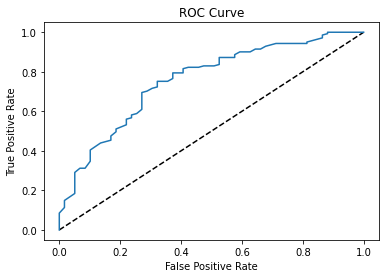

In [28]:
# DON'T WRITE HERE